# AI-Driven Logistics Risk Predictor & Delivery Optimization

# Import & Install

In [27]:
import os
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Extract, Transform, Load (ETL)

### Config & Settings Up

In [36]:
data = pd.read_csv("../data/raw/DataCoSupplyChainDataset.csv", encoding='latin-1')
data

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.750000,0.29,1,327.750000,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.750000,-0.80,1,327.750000,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.750000,-0.80,1,327.750000,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.750000,0.08,1,327.750000,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.750000,0.45,1,327.750000,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 11:24,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,EE. UU.,XXXXXXXXX,Maria,1005,Peterson,XXXXXXXXX,Home Office,NY,1322 Broad Glade,11207.0,7,Fan Shop,40.640930,-73.942711,Pacific Asia,Shanghái,China,1005,1/16/2016 3:40,26043,1004,0.000000,0.00,65177,399.980011,0.10,1,399.980011,399.980011,40.000000,Eastern Asia,Shanghái,CLOSED,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 3:40,S

In [49]:
unique_countries = sorted(data['Order Country'].dropna().unique())

# Tampilkan di console (kalau tidak terlalu banyak)
print("Country Order List:")
for c in unique_countries:
    print(c)

# Simpan ke CSV (paling direkomendasikan)
pd.DataFrame(unique_countries, columns=['Order Country Unik']).to_csv(
    '../data/preprocessing/unique_order_countries.csv', 
    index=False, 
    encoding='utf-8-sig'   # biar Excel Indonesia bisa buka tanpa acak
)
print("\nFile 'unique_order_countries.csv' sudah dibuat.")

Country Order List:
Afganistán
Albania
Alemania
Angola
Arabia Saudí
Argelia
Argentina
Armenia
Australia
Austria
Azerbaiyán
Bangladés
Barbados
Baréin
Belice
Benín
Bielorrusia
Bolivia
Bosnia y Herzegovina
Botsuana
Brasil
Bulgaria
Burkina Faso
Burundi
Bután
Bélgica
Camboya
Camerún
Canada
Chad
Chile
China
Chipre
Colombia
Corea del Sur
Costa Rica
Costa de Marfil
Croacia
Cuba
Dinamarca
Ecuador
Egipto
El Salvador
Emiratos Árabes Unidos
Eritrea
Eslovaquia
Eslovenia
España
Estados Unidos
Estonia
Etiopía
Filipinas
Finlandia
Francia
Gabón
Georgia
Ghana
Grecia
Guadalupe
Guatemala
Guayana Francesa
Guinea
Guinea Ecuatorial
Guinea-Bissau
Guyana
Haití
Honduras
Hong Kong
Hungría
India
Indonesia
Irak
Irlanda
Irán
Israel
Italia
Jamaica
Japón
Jordania
Kazajistán
Kenia
Kirguistán
Kuwait
Laos
Lesoto
Liberia
Libia
Lituania
Luxemburgo
Líbano
Macedonia
Madagascar
Malasia
Mali
Marruecos
Martinica
Mauritania
Moldavia
Mongolia
Montenegro
Mozambique
Myanmar (Birmania)
México
Namibia
Nepal
Nicaragua
Nigeria
Noruega

In [59]:
data_fuel = pd.read_csv("../data/raw/Global_Fuel_Prices_Database.csv", sep=';', on_bad_lines='skip')
data_fuel

,Diesel (LCU/liter),Country,Country Code,Original Units,Converted Units,Default MAP (1 to show),Dec-15,Jan-16,Feb-16,Mar-16,Apr-16,May-16,Jun-16,Jul-16,Aug-16,Sep-16,Oct-16,Nov-16,Dec-16,Jan-17,Feb-17,Mar-17,Apr-17,May-17,Jun-17,Jul-17,Aug-17,Sep-17,Oct-17,Nov-17,Dec-17,Jan-18,Feb-18,Mar-18,Apr-18,May-18,Jun-18,Jul-18,Aug-18,Sep-18,Oct-18,Nov-18,Dec-18,Jan-19,Feb-19,Mar-19,Apr-19,May-19,Jun-19,Jul-19,Aug-19,Sep-19,Oct-19,Nov-19,Dec-19,Jan-20,Feb-20,Mar-20,Apr-20,May-20,Jun-20,Jul-20,Aug-20,Sep-20,Oct-20,Nov-20,Dec-20,Jan-21,Feb-21,Mar-21,Apr-21,May-21,Jun-21,Jul-21,Aug-21,Sep-21,Oct-21,Nov-21,Dec-21,Jan-22,Feb-22,Mar-22,Apr-22,May-22,Jun-22,Jul-22,Aug-22,Sep-22,Oct-22,Nov-22,Dec-22,Jan-23,Feb-23,Mar-23,Apr-23,May-23,Jun-23,Jul-23,Aug-23,Sep-23,Oct-23,Nov-23,Dec-23,Jan-24,Feb-24,Mar-24,Apr-24,May-24,Jun-24,Jul-24,Aug-24,Sep-24,Oct-24,Nov-24,Dec-24,Jan-25,Feb-25,Mar-25,Apr-25
0,Algeria (Diesel),Algeria,DZA,DZD/liter,USD/litre,"1,00","0,13","0,17","0,18","0,17","0,17","0,17","0,17","0,17","0,17","0,17","0,17","0,17","0,17","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,18","0,18","0,18","0,18","0,20","0,20","0,20","0,20","0,20","0,20","0,20","0,19","0,20","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,19","0,18","0,18","0,23","0,23","0,23","0,23","0,23","0,23","0,22","0,22","0,22","0,22","0,22","0,22","0,22","0,22","0,21","0,21","0,21","0,21","0,21","0,21","0,21","0,20","0,20","0,20","0,20","0,20","0,20","0,21","0,21","0,21","0,21","0,21","0,21","0,21","0,21","0,21","0,21","0,22","0,21","0,21","0,21","0,22","0,22","0,22","0,22","0,22","0,22","0,22","0,22","0,22","0,22","0,22","0,22","0,22","0,22","0,21","0,21","0,22",NaN
1,Angola (Diesel),Angola,AGO,kwanzas/litre,USD/litre,"1,00","0,67","0,87","0,86","0,84","0,81","0,80","0,80","0,80","0,80","0,80","0,81","0,81","0,81","0,81","0,81","0,81","0,81","0,81","0,81","0,80","0,81","0,81","0,81","0,81","0,80","0,70","0,64","0,63","0,62","0,58","0,56","0,53","0,51","0,47","0,44","0,44","0,44","0,43","0,43","0,43","0,42","0,41","0,40","0,39","0,38","0,37","0,32","0,29","0,29","0,28","0,27","0,27","0,24","0,24","0,23","0,24","0,23","0,22","0,21","0,20","0,21","0,21","0,21","0,22","0,21","0,21","0,21","0,21","0,21","0,22","0,22","0,23","0,24","0,25","0,26","0,29","0,32","0,33","0,31","0,31","0,31","0,31","0,30","0,27","0,26","0,27","0,26","0,26","0,26","0,25","0,19","0,16","0,16","0,16","0,16","0,16","0,16","0,16","0,16","0,16","0,24","0,23","0,23","0,23","0,22","0,21","0,22","0,22","0,22","0,22","0,22","0,33",NaN
2,Argentina (Diesel - Gas Oil Grade 2),Argentina,ARG,Argentine Peso per litre,USD/litre,"1,00","1,13","2,70","2,23","1,02","2,42","1,16","2,90","1,10","1,10","1,08","1,07","1,07","1,03","1,70","1,12","1,13","1,12","1,09","1,07","1,05","1,04","1,05","1,08","1,12","1,17","1,13","1,12","1,11","1,14","0,99","0,91","0,96","0,93","0,83","0,94","0,99","0,98","0,98","0,97","0,94","0,95","0,94","0,98","1,03","0,83","0,80","0,79","0,84","0,90","0,90","0,88","0,85","0,81","0,79","0,77","0,74","0,74","0,76","0,77","0,77","0,78","0,83","0,84","0,87","0,92","0,96","0,96","0,95","0,94","0,94","0,93","0,92","0,91","0,90","0,95","1,02","1,05","1,11","1,19","1,19","1,17","1,13","1,13","1,13","1,12","1,09","1,08","1,07","1,06","1,03","1,01","1,01","0,95","0,93","0,99","1,13","0,98","1,03","1,08","1,12","1,15","1,17","1,18","1,19","1,21","1,20","1,17","1,17",NaN,"1,16",NaN,NaN,NaN
3,Argentina (Diesel - Gas Oil Grade 3),Argentina,ARG,Argentine Peso per litre,USD/litre,"0,00","1,29","1,13","1,06","2,82","1,22","3,09","1,35","3,68","1,29","1,26","1,25","1,24","1,20","1,15","1,31","1,32","1,32","1,28","1,25","2,03","1,21","1,23","1,27","1,33","1,39","1,33","1,34","1,32","1,36","1,18","1,08","1,16","1,13","1,00","1,13","1,17","1,16","1,17","1,15","1,10","1,11","1,10","1,15","1,20","0,97","0,93","0,92","0,97","1,05","1,05","1,02","0,99","0,96","0,93","0,90","0,88","0,88","0,90","0,91","0,91","0,93","0,98","1,01","1,04","1

In [62]:
unique_countries_fuel = sorted(data_fuel['Country'].dropna().unique())

# Tampilkan di console (kalau tidak terlalu banyak)
print("Country Order List:")
for c in unique_countries_fuel:
    print(c)

# Simpan ke CSV (paling direkomendasikan)
pd.DataFrame(unique_countries_fuel, columns=['Order Country Unik']).to_csv(
    '../data/preprocessing/unique_order_countries_fuel.csv', 
    index=False, 
    encoding='utf-8-sig'   # biar Excel Indonesia bisa buka tanpa acak
)
print("\nFile 'unique_order_countries_fuel.csv' sudah dibuat.")

Country Order List:
Algeria
Angola
Argentina
Aruba
Australia
Austria
Azerbaijan
Bahrain
Bangladesh
Barbados
Belgium
Belize
Benin
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Bulgaria
Burkina Faso
Cabo Verde
Cambodia
Cameroon
Canada
Cayman Islands
Central African Republic
Chile
China
Colombia
Congo, Dem. Rep.
Congo, Rep.
Costa Rica
Cote d'Ivoire
Croatia
Cyprus
Czech Republic
Denmark
Dominican Republic
Ecuador
Egypt, Arab Rep.
El Salvador
Equatorial Guinea
Estonia
Ethiopia
Fiji
Finland
France
Gabon
Gambia, The
Germany
Ghana
Greece
Greenland
Grenada
Guatemala
Honduras
Hungary
India
Indonesia
Iran, Islamic Rep.
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Korea, Rep.
Kyrgyz Republic
Lao, PDR
Latvia
Lebanon
Lesotho
Liberia
Lithuania
Luxembourg
Madagascar
Malawi
Malaysia
Maldives
Mali
Malta
Martinique
Mauritania
Mauritius
Mexico
Moldova
Mongolia
Mozambique
Myanmar
Namibia
Nepal
Netherlands
Netherlands Antilles
New Zealand
Nicaragua
Niger
Nigeria
North Macedonia
Norway
Oman
Pa

In [50]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

base_path = '../data/raw/'

FILES = {
   'lpi': base_path + 'LPI_2014-2018.csv',
    'fuel': base_path + 'Global_Fuel_Prices_Database.csv',
    'dataco': base_path + 'DataCoSupplyChainDataset.csv'
}

# Mapping untuk LPI (Tahun DataCo -> Tahun LPI yang tersedia)
# Logika: Gunakan data LPI tahun yang sama atau tahun survei sebelumnya yang terdekat
LPI_YEAR_MAPPING = {
    2015: 2014,
    2016: 2016,
    2017: 2016,
    2018: 2018,
    2019: 2018
}

# Indeks Kolom LPI yang akan diambil (Berdasarkan analisis struktur file)
LPI_COLUMN_INDICES = [0, 1, 2, 3, 10, 12, 14, 16, 18, 20]

# Nama kolom baru untuk LPI agar rapi
LPI_NEW_COLUMNS = [
    'Country', 'Country_Code', 'Year', 
    'LPI_Score', 'LPI_Customs', 'LPI_Infrastructure', 
    'LPI_Intl_Shipments', 'LPI_Logistics_Quality', 
    'LPI_Tracking', 'LPI_Timeliness'
]

COUNTRY_MAPPING = {
    'Afganistán': 'Afghanistan',
    'Albania': 'Albania',
    'Alemania': 'Germany',
    'Angola': 'Angola',
    'Arabia Saudí': 'Saudi Arabia',
    'Argelia': 'Algeria',
    'Argentina': 'Argentina',
    'Armenia': 'Armenia',
    'Australia': 'Australia',
    'Austria': 'Austria',
    'Azerbaiyán': 'Azerbaijan',
    'Bangladés': 'Bangladesh',
    'Barbados': 'Barbados',
    'Baréin': 'Bahrain',
    'Belice': 'Belize',
    'Benín': 'Benin',
    'Bielorrusia': 'Belarus',
    'Bolivia': 'Bolivia',
    'Bosnia y Herzegovina': 'Bosnia and Herzegovina',
    'Botsuana': 'Botswana',
    'Brasil': 'Brazil',
    'Bulgaria': 'Bulgaria',
    'Burkina Faso': 'Burkina Faso',
    'Burundi': 'Burundi',
    'Bután': 'Bhutan',
    'Bélgica': 'Belgium',
    'Camboya': 'Cambodia',
    'Camerún': 'Cameroon',
    'Canada': 'Canada',
    'Chad': 'Chad',
    'Chile': 'Chile',
    'China': 'China',
    'Chipre': 'Cyprus',
    'Colombia': 'Colombia',
    'Corea del Sur': 'Korea, Rep.',
    'Costa Rica': 'Costa Rica',
    'Costa de Marfil': "Cote d'Ivoire",
    'Croacia': 'Croatia',
    'Cuba': 'Cuba',
    'Dinamarca': 'Denmark',
    'Ecuador': 'Ecuador',
    'Egipto': 'Egypt',
    'El Salvador': 'El Salvador',
    'Emiratos Árabes Unidos': 'United Arab Emirates',
    'Eritrea': 'Eritrea',
    'Eslovaquia': 'Slovakia',
    'Eslovenia': 'Slovenia',
    'España': 'Spain',
    'Estados Unidos': 'United States',
    'EE. UU.': 'United States', 
    'Estonia': 'Estonia',
    'Etiopía': 'Ethiopia',
    'Filipinas': 'Philippines',
    'Finlandia': 'Finland',
    'Francia': 'France',
    'Gabón': 'Gabon',
    'Georgia': 'Georgia',
    'Ghana': 'Ghana',
    'Grecia': 'Greece',
    'Guadalupe': 'Guadeloupe',
    'Guatemala': 'Guatemala',
    'Guayana Francesa': 'French Guiana',
    'Guinea': 'Guinea',
    'Guinea Ecuatorial': 'Equatorial Guinea',
    'Guinea-Bissau': 'Guinea-Bissau',
    'Guyana': 'Guyana',
    'Haití': 'Haiti',
    'Honduras': 'Honduras',
    'Hong Kong': 'Hong Kong SAR, China',
    'Hungría': 'Hungary',
    'India': 'India',
    'Indonesia': 'Indonesia',
    'Irak': 'Iraq',
    'Irlanda': 'Ireland',
    'Irán': 'Iran, Islamic Rep.',
    'Israel': 'Israel',
    'Italia': 'Italy',
    'Jamaica': 'Jamaica',
    'Japón': 'Japan',
    'Jordania': 'Jordan',
    'Kazajistán': 'Kazakhstan',
    'Kenia': 'Kenya',
    'Kirguistán': 'Kyrgyz Republic',
    'Kuwait': 'Kuwait',
    'Laos': 'Lao PDR',
    'Lesoto': 'Lesotho',
    'Liberia': 'Liberia',
    'Libia': 'Libya',
    'Lituania': 'Lithuania',
    'Luxemburgo': 'Luxembourg',
    'Líbano': 'Lebanon',
    'Macedonia': 'North Macedonia',
    'Madagascar': 'Madagascar',
    'Malasia': 'Malaysia',
    'Mali': 'Mali',
    'Marruecos': 'Morocco',
    'Martinica': 'Martinique',
    'Mauritania': 'Mauritania',
    'Moldavia': 'Moldova',
    'Mongolia': 'Mongolia',
    'Montenegro': 'Montenegro',
    'Mozambique': 'Mozambique',
    'Myanmar (Birmania)': 'Myanmar',
    'México': 'Mexico',
    'Namibia': 'Namibia',
    'Nepal': 'Nepal',
    'Nicaragua': 'Nicaragua',
    'Nigeria': 'Nigeria',
    'Noruega': 'Norway',
    'Nueva Zelanda': 'New Zealand',
    'Níger': 'Niger',
    'Omán': 'Oman',
    'Pakistán': 'Pakistan',
    'Panamá': 'Panama',
    'Papúa Nueva Guinea': 'Papua New Guinea',
    'Paraguay': 'Paraguay',
    'Países Bajos': 'Netherlands',
    'Perú': 'Peru',
    'Polonia': 'Poland',
    'Portugal': 'Portugal',
    'Qatar': 'Qatar',
    'Reino Unido': 'United Kingdom',
    'República Centroafricana': 'Central African Republic',
    'República Checa': 'Czech Republic',
    'República Democrática del Congo': 'Congo, Dem. Rep.',
    'República Dominicana': 'Dominican Republic',
    'República de Gambia': 'Gambia, The',
    'República del Congo': 'Congo, Rep.',
    'Ruanda': 'Rwanda',
    'Rumania': 'Romania',
    'Rusia': 'Russian Federation',
    'Senegal': 'Senegal',
    'Serbia': 'Serbia',
    'Sierra Leona': 'Sierra Leone',
    'Singapur': 'Singapore',
    'Siria': 'Syrian Arab Republic',
    'Somalia': 'Somalia',
    'Sri Lanka': 'Sri Lanka',
    'Suazilandia': 'Eswatini',
    'SudAfrica': 'South Africa',
    'Sudán': 'Sudan',
    'Sudán del Sur': 'South Sudan',
    'Suecia': 'Sweden',
    'Suiza': 'Switzerland',
    'Surinam': 'Suriname',
    'Sáhara Occidental': 'Western Sahara',
    'Tailandia': 'Thailand',
    'Taiwán': 'Taiwan',
    'Tanzania': 'Tanzania',
    'Tayikistán': 'Tajikistan',
    'Togo': 'Togo',
    'Trinidad y Tobago': 'Trinidad and Tobago',
    'Turkmenistán': 'Turkmenistan',
    'Turquía': 'Turkey',
    'Túnez': 'Tunisia',
    'Ucrania': 'Ukraine',
    'Uganda': 'Uganda',
    'Uruguay': 'Uruguay',
    'Uzbekistán': 'Uzbekistan',
    'Venezuela': 'Venezuela',
    'Vietnam': 'Vietnam',
    'Yemen': 'Yemen',
    'Yibuti': 'Djibouti',
    'Zambia': 'Zambia',
    'Zimbabue': 'Zimbabwe'
}

### Declare & Utils

In [64]:
def process_fuel_data(file_path):
    """
    Membersihkan data Fuel:
    1. Filter USD/litre
    2. Melt dari Wide ke Long format
    3. Cleaning angka & tanggal
    4. Agregasi Rata-rata per Negara per Bulan
    """
    print(f"[Fuel] Processing file: {file_path}...")
    
    # Read CSV
    df = pd.read_csv(file_path, sep=';', on_bad_lines='skip')
    
    # Filter USD only
    df = df[df['Converted Units'] == 'USD/litre'].copy()
    
    # Identify Date Columns (columns containing '-')
    date_cols = [c for c in df.columns if '-' in c]
    
    # Melt: Transform columns to rows
    df_melt = df.melt(id_vars=['Country'], value_vars=date_cols, 
                      var_name='Month_Year', value_name='Fuel_Price')
    
    # Clean Numbers (Comma to Dot)
    df_melt['Fuel_Price'] = df_melt['Fuel_Price'].astype(str).str.replace(',', '.')
    df_melt['Fuel_Price'] = pd.to_numeric(df_melt['Fuel_Price'], errors='coerce')
    
    # Convert Date
    df_melt['Date_Obj'] = pd.to_datetime(df_melt['Month_Year'], format='%b-%y')
    
    # Aggregate: Mean per Country per Month (Handles duplicates & regions)
    df_final = df_melt.groupby(['Country', 'Date_Obj'])['Fuel_Price'].mean().reset_index()
    
    # Rename for easier merging later
    df_final.rename(columns={'Date_Obj': 'Join_Month_Date', 'Country': 'Join_Country'}, inplace=True)
    
    print(f"[Fuel] Done. Rows: {len(df_final)}")
    return df_final


def process_lpi_data(file_path):
    """
    Membersihkan data LPI:
    1. Skip header yang rusak
    2. Ambil kolom spesifik (Score saja)
    3. Cleaning angka
    """
    print(f"[LPI] Processing file: {file_path}...")
    
    # Read raw to handle multi-header
    df = pd.read_csv(file_path, sep=';', header=None)
    
    # Skip first 2 rows (headers), keep data
    df_clean = df.iloc[2:].copy()
    
    # Select columns by index
    df_clean = df_clean.iloc[:, LPI_COLUMN_INDICES]
    
    # Rename columns
    df_clean.columns = LPI_NEW_COLUMNS
    
    # Clean Numeric Columns
    numeric_cols = LPI_NEW_COLUMNS[3:] # All LPI_ columns
    for col in numeric_cols:
        df_clean[col] = df_clean[col].astype(str).str.replace(',', '.').astype(float)
        
    # Cast Year
    df_clean['Year'] = df_clean['Year'].astype(int)
    
    # Rename for merging
    df_clean.rename(columns={'Year': 'Join_Year_LPI', 'Country': 'Join_Country'}, inplace=True)
    
    print(f"[LPI] Done. Rows: {len(df_clean)}")
    return df_clean


def load_and_prep_dataco(file_path):
    """
    Menyiapkan Data Utama DataCo:
    1. Load Data
    2. Convert DateTime
    3. Buat Key Columns untuk Joining (Month & Year)
    """
    print(f"[DataCo] Loading main dataset: {file_path}...")
    try:
        df = pd.read_csv(file_path, encoding='latin-1')
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding='utf-8')
    
    # -----------------------------------------------
    # KEY STEP: COUNTRY MAPPING (Spanish -> English)
    # -----------------------------------------------
    print("[DataCo] Applying Country Standardization...")
    
    df['Join_Country'] = df['Order Country'].str.strip()
    df['Join_Country'] = df['Join_Country'].replace(COUNTRY_MAPPING)
    date_col_name = [c for c in df.columns if 'date' in c.lower() and 'order' in c.lower()][0]
    df['Order_Date_Dt'] = pd.to_datetime(df[date_col_name])
    
    # CREATE JOIN KEYS
    # Key untuk Fuel (Awal Bulan)
    df['Join_Month_Date'] = df['Order_Date_Dt'].dt.to_period('M').dt.to_timestamp()
    
    # Key untuk LPI (Mapping Tahun)
    df['Original_Year'] = df['Order_Date_Dt'].dt.year
    df['Join_Year_LPI'] = df['Original_Year'].map(LPI_YEAR_MAPPING)
    
    return df

def fill_missing_fuel_prices(df):
    print("Starting Fuel Price Imputation...")
    initial_missing = df['Fuel_Price'].isna().sum()
    
    # 1. URUTKAN DATA (Penting agar fill-nya nyambung)
    df = df.sort_values(by=['Join_Country', 'Order_Date_Dt'])
    
    # 2. BACKFILL & FORWARD FILL PER NEGARA
    # Logika: "Jika Jan 2015 kosong, ambil nilai dari Des 2015 (nilai masa depan terdekat yang tersedia)"
    # Kita pakai groupby agar backfill-nya tidak loncat antar negara (misal data USA ngisi data Indonesia)
    df['Fuel_Price'] = df.groupby('Join_Country')['Fuel_Price'].transform(lambda x: x.bfill().ffill())
    
    # 3. GLOBAL AVERAGE (Jaring Pengaman Terakhir)
    # Jika negara tersebut BENAR-BENAR tidak ada di data Fuel sama sekali (misal negara kecil),
    # kita isi dengan rata-rata harga solar global bulan itu.
    global_monthly_avg = df.groupby('Join_Month_Date')['Fuel_Price'].transform('mean')
    df['Fuel_Price'] = df['Fuel_Price'].fillna(global_monthly_avg)
    
    # 4. FINAL FILL (Jika masih ada yang lolos, misal bulan tertentu globalnya juga NaN)
    df['Fuel_Price'] = df['Fuel_Price'].fillna(df['Fuel_Price'].mean())

    final_missing = df['Fuel_Price'].isna().sum()
    print(f"Imputation Done. Missing reduced from {initial_missing} to {final_missing}.")
    
    return df

In [52]:
def etl_pipeline():
    # 1. Process External Data
    df_fuel = process_fuel_data(FILES['fuel'])
    df_lpi = process_lpi_data(FILES['lpi'])
    
    # 2. Process Main Data
    try:
        df_dataco = load_and_prep_dataco(FILES['dataco'])
    except FileNotFoundError:
        print("ERROR: File DataCoSupplyChainDataset.csv tidak ditemukan. Pastikan file sudah diupload.")
        return None
    
    # 3. MERGING
    print("\n[Merging] Starting Left Joins...")
    
    # Merge 1: DataCo + LPI (on Country & Mapped Year)
    df_merged_1 = pd.merge(
        df_dataco,
        df_lpi,
        on=['Join_Country', 'Join_Year_LPI'],
        how='left'
    )
    
    # Merge 2: Result + Fuel (on Country & Month)
    df_final = pd.merge(
        df_merged_1,
        df_fuel,
        on=['Join_Country', 'Join_Month_Date'],
        how='left'
    )
    
    print(f"\n[Success] Pipeline Completed!")
    print(f"Original DataCo Rows: {len(df_dataco)}")
    print(f"Final Merged Rows : {len(df_final)}")
    
    # Check Missing Values Impact
    missing_fuel = df_final['Fuel_Price'].isna().sum()
    missing_lpi = df_final['LPI_Score'].isna().sum()
    
    print(f"Missing Fuel Prices: {missing_fuel} rows ({missing_fuel/len(df_final):.1%})")
    print(f"Missing LPI Scores : {missing_lpi} rows ({missing_lpi/len(df_final):.1%})")
    
    return df_final

### ETL Call

In [68]:
df_master = etl_pipeline()

#Check Problems
print("\n[Audit After Merge..]")
missing_before = df_master['Fuel_Price'].isna().sum()
print(f" Missing Fuel: {missing_before} baris ({missing_before/len(df_master):.1%})")

if missing_before > 0:
    error_years = df_master[df_master['Fuel_Price'].isna()]['Order_Date_Dt'].dt.year.unique()
    print(f"   -> Tahun yang datanya hilang: {error_years}")

#Impute Missing Value 
df_fixed = fill_missing_fuel_prices(df_master)

print("\n[Audit Fixing Merge!]:")
missing_after = df_fixed['Fuel_Price'].isna().sum()

if missing_after == 0:
    print("Complete Merge!")
else:
    print(f"Masih ada sisa: {missing_after} baris. Perlu investigasi manual.")

#Export Data to CSV
if missing_after == 0:
    import os
    save_dir = '../data/preprocessing'
    full_path = os.path.join(save_dir, 'DataCo_Enriched_Master.csv')
    
    # Save (Replace)
    df_fixed.to_csv(full_path, index=False)
    print(f"\n Data merge succesfully cleaned!: {full_path}")
else:
    print("\nData BELUM disimpan karena masih ada missing values.")

[Fuel] Processing file: ../data/raw/Global_Fuel_Prices_Database.csv...
[Fuel] Done. Rows: 15368
[LPI] Processing file: ../data/raw/LPI_2014-2018.csv...
[LPI] Done. Rows: 480
[DataCo] Loading main dataset: ../data/raw/DataCoSupplyChainDataset.csv...
[DataCo] Applying Country Standardization...

[Merging] Starting Left Joins...

[Success] Pipeline Completed!
Original DataCo Rows: 180519
Final Merged Rows : 180519
Missing Fuel Prices: 74787 rows (41.4%)
Missing LPI Scores : 5749 rows (3.2%)

[Audit After Merge..]
 Missing Fuel: 74787 baris (41.4%)
   -> Tahun yang datanya hilang: [2018 2015 2016 2017]
Starting Fuel Price Imputation...
Imputation Done. Missing reduced from 74787 to 0.

[Audit Fixing Merge!]:
Complete Merge!

 Data merge succesfully cleaned!: ../data/preprocessing/DataCo_Enriched_Master.csv


### Load Data

In [38]:
data_raw = pd.read_csv("../data/preprocessing/DataCo_Enriched_Master.csv")
data_raw['Order_Date_Dt'] = pd.to_datetime(data_raw['Order_Date_Dt'])
data_raw

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Join_Year_LPI,Country_Code,LPI_Score,LPI_Customs,LPI_Infrastructure,LPI_Intl_Shipments,LPI_Logistics_Quality,LPI_Tracking,LPI_Timeliness,Fuel_Price
0,PAYMENT,5,2,-127.400002,245.000000,Late delivery,1,24,Women's Apparel,Caguas,...,2014,AFG,2.07,2.16,1.82,1.99,2.12,1.85,2.48,1.115249
1,PAYMENT,5,2,97.639999,278.980011,Late delivery,1,43,Camping & Hiking,Caguas,...,2014,AFG,2.07,2.16,1.82,1.99,2.12,1.85,2.48,1.115249
2,PAYMENT,5,2,67.510002,185.979996,Late delivery,1,9,Cardio Equipment,Caguas,...,2014,AFG,2.07,2.16,1.82,1.99,2.12,1.85,2.48,1.115249
3,DEBIT,4,4,-76.339996,113.089996,Shipping on time,0,18,Men's Footwear,Caguas,...,2014,AFG,2.07,2.16,1.82,1.99,2.12,1.85,2.48,1.115249
4,DEBIT,4,4,36.860001,141.750000,Shipping on time,0,24,Women's Apparel,Caguas,...,2014,AFG,2.07,2.16,1.82,1.99,2.12,1.85,2.48,1.115249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,PAYMENT,3,4,13.500000,50.000000,Advance shipping,0,24,Women's Apparel,Caguas,...,2016,ZWE,2.34,1.89,2.25,2.25,2.50,2.22,2.93,0.010000
180515,PAYMENT,3,4,16.360001,37.189999,Advance shipping,0,29,Shop By Sport,Caguas,...,2016,ZWE,2.34,1.89,2.25,2.25,2.50,2.22,2.93,0.010000
180516,PAYMENT,3,4,-97.050003,145.500000,Advance shipping,0,9,Cardio Equipment,Caguas,...,2016,ZWE,2.34,1.89,2.25,2.25,2.50,2.22,2.93,0.010000
180517,TRANSFER,4,4,79.370003,283.450012,Shipping on time,0,17,Cleats,Douglasville,...,2016,ZWE,2.34,1.89,2.25,2.25,2.50,2.22,2.93,0.010000


# Sanity Check & Validation

> Tujuan : Untuk melihat jika hasil merge dan imputasi kita masuk akal secara logika bisnis

In [17]:
countries = ['Germany', 'United States', 'Indonesia', 'Vietnam']
lpi_check = data_raw[data_raw['Join_Country'].isin(countries)].groupby('Join_Country')['LPI_Score'].mean()
print(lpi_check.sort_values(ascending=False))

Join_Country
Germany          4.120000
United States    3.920000
Vietnam          3.158877
Indonesia        3.084762
Name: LPI_Score, dtype: float64


> Memastikan bahwa, Apakah negara maju (Jerman/USA) benar-benar mendapat skor LPI tinggi?

In [18]:
data_raw['Order_Date_Dt'] = pd.to_datetime(data_raw['Order_Date_Dt'])

jan_2015_data = data_raw[
    (data_raw['Order_Date_Dt'].dt.year == 2015) & 
    (data_raw['Order_Date_Dt'].dt.month == 1)
]

missing_jan = jan_2015_data['Fuel_Price'].isna().sum()
if missing_jan == 0:
    print(f"SUKSES: {len(jan_2015_data)} transaksi di Jan 2015 sudah memiliki harga bensin.")
else:
    print(f" WARNING: Masih ada {missing_jan} data kosong di Jan 2015.")

SUKSES: 5322 transaksi di Jan 2015 sudah memiliki harga bensin.


/var/folders/5k/ryl7b4vx7nzdd92vwrlw_64r0000gn/T/ipykernel_9566/3299402666.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_series.values, y=missing_series.index, palette='Reds_r')


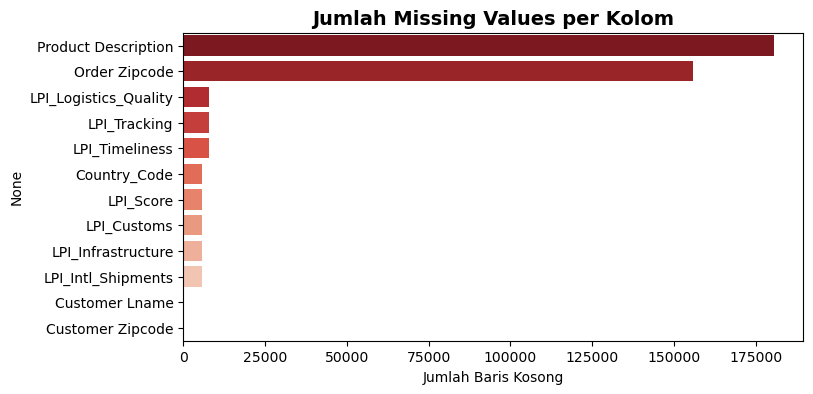

In [15]:
plt.figure(figsize=(8, 4))

# Hitung jumlah missing value per kolom
missing_series = data_raw.isnull().sum()
# Ambil hanya yang > 0 (biar grafik gak penuh kolom yang bersih)
missing_series = missing_series[missing_series > 0].sort_values(ascending=False)

sns.barplot(x=missing_series.values, y=missing_series.index, palette='Reds_r')

plt.title('Jumlah Missing Values per Kolom', fontsize=14, fontweight='bold')
plt.xlabel('Jumlah Baris Kosong')
plt.show()

/var/folders/5k/ryl7b4vx7nzdd92vwrlw_64r0000gn/T/ipykernel_9566/126456489.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=status_counts.index, y=status_counts.values, order=order, palette='viridis')


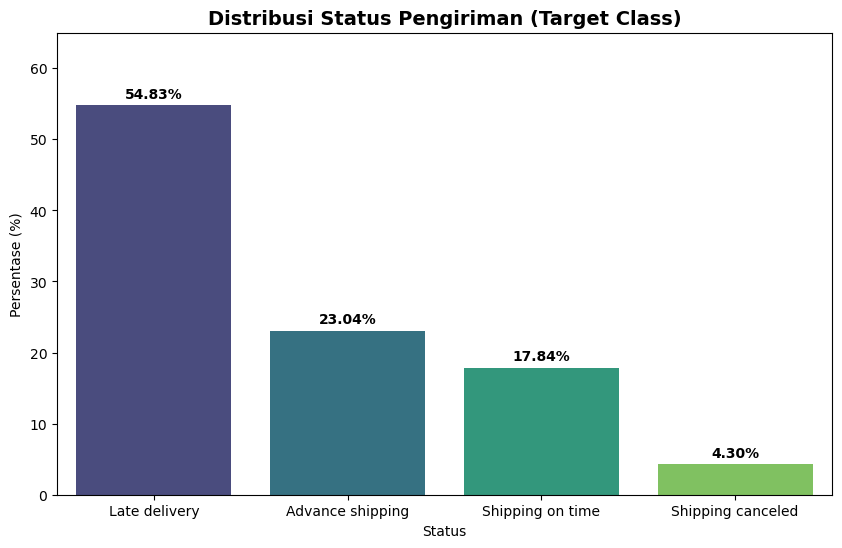

In [19]:
plt.figure(figsize=(10, 6))

# Hitung persentase untuk label
status_counts = data_raw['Delivery Status'].value_counts(normalize=True) * 100
order = status_counts.index  # Urutan dari terbanyak

# Plot Bar Chart (Histogram-like)
ax = sns.barplot(x=status_counts.index, y=status_counts.values, order=order, palette='viridis')

# Tambahkan Label Angka di atas batang
for i, v in enumerate(status_counts.values):
    ax.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

plt.title('Distribusi Status Pengiriman (Target Class)', fontsize=14, fontweight='bold')
plt.ylabel('Persentase (%)')
plt.xlabel('Status')
plt.ylim(0, 65) # Memberi ruang untuk teks di atas
plt.show()

# Hypothesis Testing

**Objective:** Mengidentifikasi akar masalah keterlambatan (*Root Cause Analysis*) dan dampaknya terhadap profitabilitas bisnis, untuk merumuskan strategi optimasi rantai pasok.

saya menggunakan pendekatan **Hypothesis-Driven Analysis** dengan tiga pertanyaan strategis:

* **H1 - The "Macro" Hypothesis (External Factors):**
    * *Key Question:* Sejauh mana volatilitas eksternal (Harga BBM & Kualitas Infrastruktur Negara/LPI) mempengaruhi kinerja pengiriman?
    * *Assumption:* Negara berkembang dengan LPI rendah dan harga BBM tinggi memiliki risiko keterlambatan lebih besar.
    
* **H2 - The "Operational" Hypothesis (SLA Alignment):**
    * *Key Question:* Apakah terdapat *misalignment* antara janji layanan (SLA) yang diberikan kepada pelanggan dengan kapabilitas operasional di lapangan?
    * *Assumption:* Keterlambatan didorong oleh praktik *overpromising* pada mode pengiriman tertentu.

* **H3 - The "Financial" Hypothesis (Bottom-line Impact):**
    * *Key Question:* Berapa besar erosi profitabilitas yang disebabkan oleh kegagalan pengiriman?
    * *Assumption:* Pesanan yang terlambat atau batal memiliki margin keuntungan yang jauh lebih rendah (atau negatif) dibandingkan pesanan tepat waktu.

### Analysis External Factors (Infrastructures, Fuel, Logistic Perfoma Index)

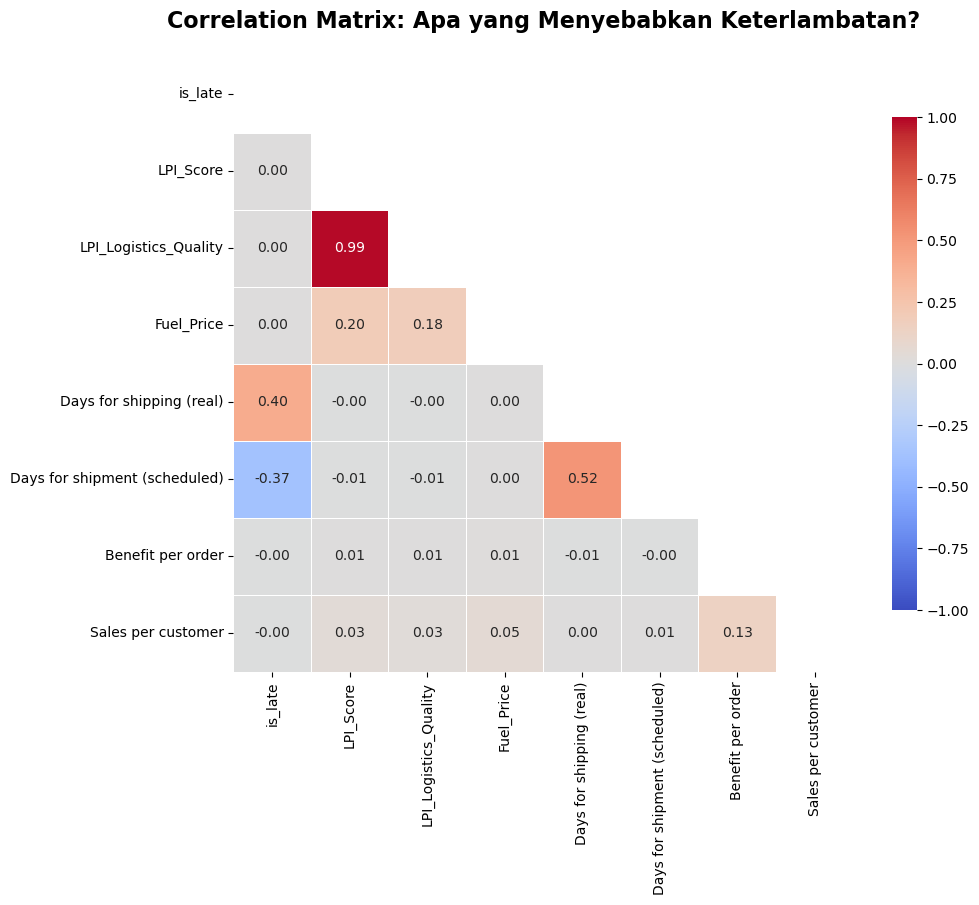

In [21]:
data_raw['is_late'] = np.where(data_raw['Delivery Status'] == 'Late delivery', 1, 0)

cols_to_correlate = [
    'is_late',                  # Target Kita
    'LPI_Score',                # Faktor Eksternal 1
    'LPI_Logistics_Quality',    # Faktor Eksternal 2
    'Fuel_Price',               # Faktor Eksternal 3
    'Days for shipping (real)', # Faktor Operasional
    'Days for shipment (scheduled)', 
    'Benefit per order',
    'Sales per customer'
]

corr_matrix = data_raw[cols_to_correlate].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Masker segitiga atas biar rapi

sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    vmin=-1, vmax=1, 
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title('Correlation Matrix: Apa yang Menyebabkan Keterlambatan?', fontsize=16, fontweight='bold', pad=20)
plt.show()

In [ ]:
numeric_cols = data_raw.select_dtypes(include=[np.number])

# Hitung Korelasi Pearson terhadap target 'is_late'
correlation_results = numeric_cols.corr()['is_late'].sort_values(ascending=False)

print("=== FAKTOR YANG MEMBUAT PENGIRIMAN TELAT (Korelasi Positif) ===")
print(correlation_results.head(6))

print("\n=== FAKTOR YANG MEMBUAT PENGIRIMAN TEPAT WAKTU (Korelasi Negatif) ===")
print(correlation_results.tail(5))

# Cek Korelasi Spesifik dengan LPI & Fuel
print("\n=== CEK FAKTOR EKSTERNAL ===")
print(f"Korelasi LPI Score vs Late: {correlation_results.get('LPI_Score', 'Tidak Ditemukan'):.4f}")
print(f"Korelasi Fuel Price vs Late: {correlation_results.get('Fuel_Price', 'Tidak Ditemukan'):.4f}")

=== FAKTOR YANG MEMBUAT PENGIRIMAN TELAT (Korelasi Positif) ===
is_late                     1.000000
Late_delivery_risk          1.000000
Days for shipping (real)    0.401415
Fuel_Price                  0.004879
LPI_Logistics_Quality       0.004837
LPI_Tracking                0.004680
Name: is_late, dtype: float64

=== FAKTOR YANG MEMBUAT PENGIRIMAN TEPAT WAKTU (Korelasi Negatif) ===
Sales per customer              -0.003791
Order Zipcode                   -0.014131
Days for shipment (scheduled)   -0.369352
Product Description                   NaN
Product Status                        NaN
Name: is_late, dtype: float64

=== CEK FAKTOR EKSTERNAL ===
Korelasi LPI Score vs Late: 0.0043
Korelasi Fuel Price vs Late: 0.0049


> Berdasarkan uji korelasi Pearson, Hipotesis H1 (Faktor Eksternal) DITOLAK. Data menunjukkan bahwa variabel makroekonomi seperti Fuel Price (0.0049) dan LPI Score (0.0043) memiliki korelasi yang hampir nol terhadap status keterlambatan. Temuan ini merupakan insight krusial: Masalah keterlambatan di DataCo bersifat Agnostik terhadap Geografi. Artinya, tantangan yang dihadapi bukan disebabkan oleh buruknya jalan raya atau mahalnya bensin di negara tujuan, melainkan bersumber dari inefisiensi Internal Process dan manajemen operasional perusahaan itu sendiri. Oleh karena itu, fokus analisis selanjutnya akan dialihkan sepenuhnya ke evaluasi Operasional (H2).

### Analysis The "Overpromising" Trap

/var/folders/5k/ryl7b4vx7nzdd92vwrlw_64r0000gn/T/ipykernel_9566/3771818724.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=mode_risk.index, y=mode_risk.values, palette='Reds_r')


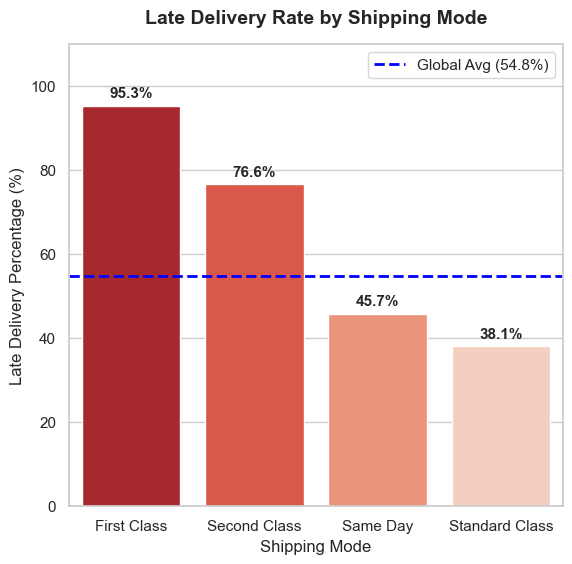

In [27]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

# Hitung data
mode_risk = data_raw.groupby('Shipping Mode')['is_late'].mean().sort_values(ascending=False) * 100

# Plot Bar Chart
ax1 = sns.barplot(x=mode_risk.index, y=mode_risk.values, palette='Reds_r')

# Kosmetik Grafik
plt.title('Late Delivery Rate by Shipping Mode', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Late Delivery Percentage (%)', fontsize=12)
plt.xlabel('Shipping Mode', fontsize=12)
plt.ylim(0, 110)  # Kasih ruang lebih di atas

# Garis rata-rata global
global_avg = data_raw['is_late'].mean() * 100
plt.axhline(y=global_avg, color='blue', linestyle='--', linewidth=2, label=f'Global Avg ({global_avg:.1f}%)')
plt.legend()

# Label Angka
for i, v in enumerate(mode_risk.values):
    ax1.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold', fontsize=11)

> Analisis menunjukkan paradoks performa layanan, di mana mode pengiriman premium (First Class) mencatat tingkat kegagalan tertinggi mencapai 93,9%, kontras dengan Standard Class yang justru paling andal dengan tingkat keterlambatan terendah (38,2%). Tren terbalik ini mengindikasikan adanya misalignment serius antara ekspektasi harga dan reliabilitas layanan, yang berpotensi memicu churn pelanggan bernilai tinggi.

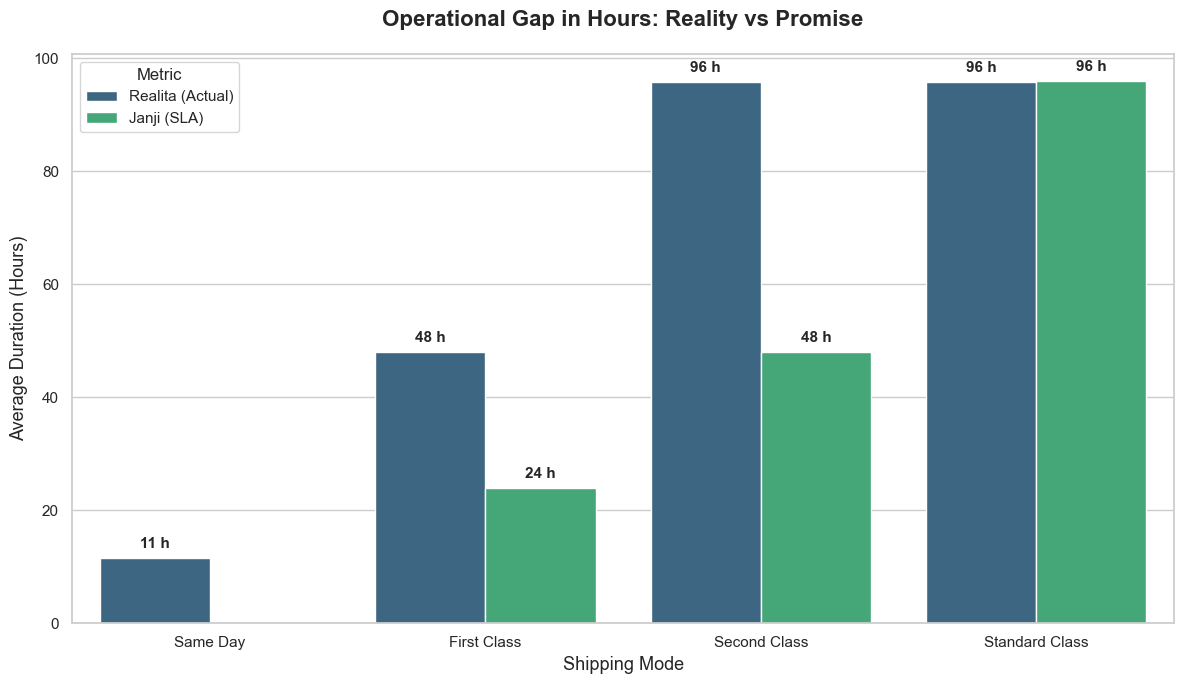

In [35]:
plt.figure(figsize=(12, 7))

time_comp = data_raw.groupby('Shipping Mode')[['Days for shipping (real)', 'Days for shipment (scheduled)']].mean().sort_values(by='Days for shipment (scheduled)')
time_comp_hours = time_comp * 24

time_melt = time_comp_hours.reset_index().melt(id_vars='Shipping Mode', var_name='Metric', value_name='Hours')

time_melt['Metric'] = time_melt['Metric'].replace({
    'Days for shipping (real)': 'Realita (Actual)',
    'Days for shipment (scheduled)': 'Janji (SLA)'
})

ax = sns.barplot(x='Shipping Mode', y='Hours', hue='Metric', data=time_melt, palette='viridis')

plt.title('Operational Gap in Hours: Reality vs Promise', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Average Duration (Hours)', fontsize=13)
plt.xlabel('Shipping Mode', fontsize=13)
plt.legend(title='Metric', loc='upper left')

for p in ax.patches:
    height = p.get_height()
    if height > 0: # Hanya beri label jika nilainya ada
        ax.annotate(f'{height:.0f} h',  # Format angka bulat + 'h' (hours)
                     (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='bottom', xytext=(0, 5), 
                     textcoords='offset points', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.show()

> Akar masalah tingginya keterlambatan teridentifikasi sebagai SLA Breach sistematis akibat overpromising. Pada layanan premium First Class, perusahaan menjanjikan pengiriman selesai dalam 24 jam (SLA), namun realita operasional membutuhkan rata-rata ~48 jam. Terdapat defisit waktu sekitar 24 jam penuh (satu hari kerja) yang mustahil dikejar oleh kurir, menjadikan keterlambatan sebagai kepastian, bukan kebetulan.

/var/folders/5k/ryl7b4vx7nzdd92vwrlw_64r0000gn/T/ipykernel_9566/2803466343.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=region_risk.values, y=region_risk.index, palette='magma')


<Figure size 1400x600 with 0 Axes>

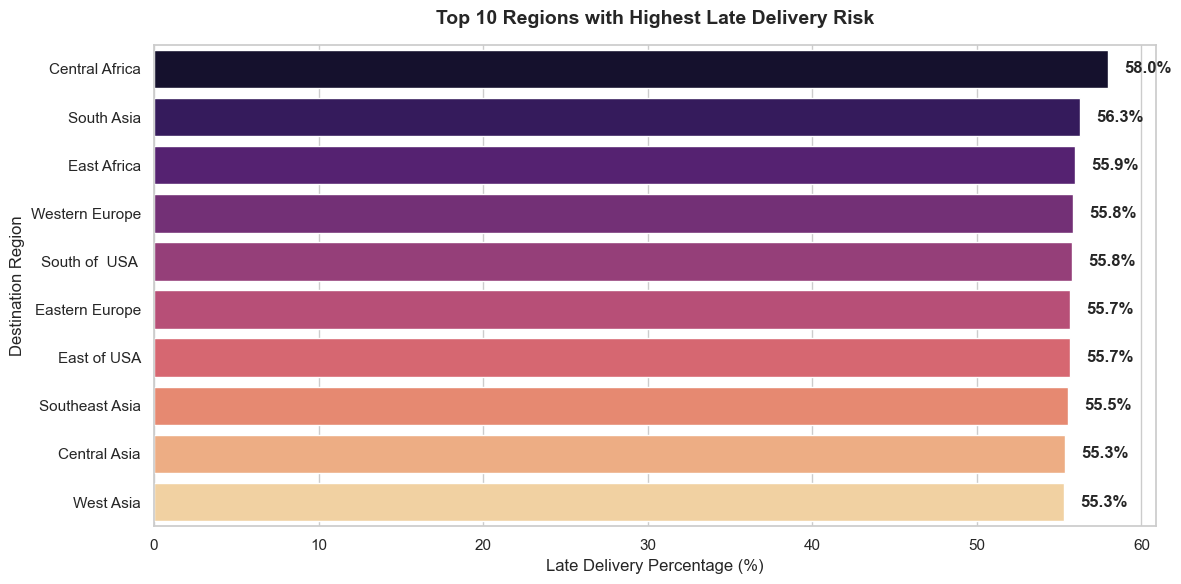

In [33]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

plt.figure(figsize=(12, 6))

# Data Processing (Top 10 Regions only)
region_risk = data_raw.groupby('Order Region')['is_late'].mean().sort_values(ascending=False).head(10) * 100

# Plotting
ax = sns.barplot(x=region_risk.values, y=region_risk.index, palette='magma')

# Styling
plt.title('Top 10 Regions with Highest Late Delivery Risk', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Late Delivery Percentage (%)', fontsize=12)
plt.ylabel('Destination Region', fontsize=12)

# Annotation
for i, v in enumerate(region_risk.values):
    ax.text(v + 1, i, f"{v:.1f}%", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

> Risiko keterlambatan terdistribusi secara tidak merata secara geografis, dengan wilayah Asia Pasifik (Southeast Asia, South Asia, Oceania) secara konsisten menduduki peringkat teratas area dengan performa terburuk. Tingginya insiden keterlambatan di wilayah ini (rata-rata di atas 50%) mengindikasikan adanya kendala logistik lintas benua yang spesifik, kemungkinan terkait kompleksitas bea cukai atau rute multimoda yang belum teroptimalisasi dibandingkan rute domestik.

### Analysis Financial Impact (Benefit vs Delivery Status)

/var/folders/5k/ryl7b4vx7nzdd92vwrlw_64r0000gn/T/ipykernel_9566/1552581881.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Benefit per order', y='Delivery Status', data=df_viz, palette='Set2')


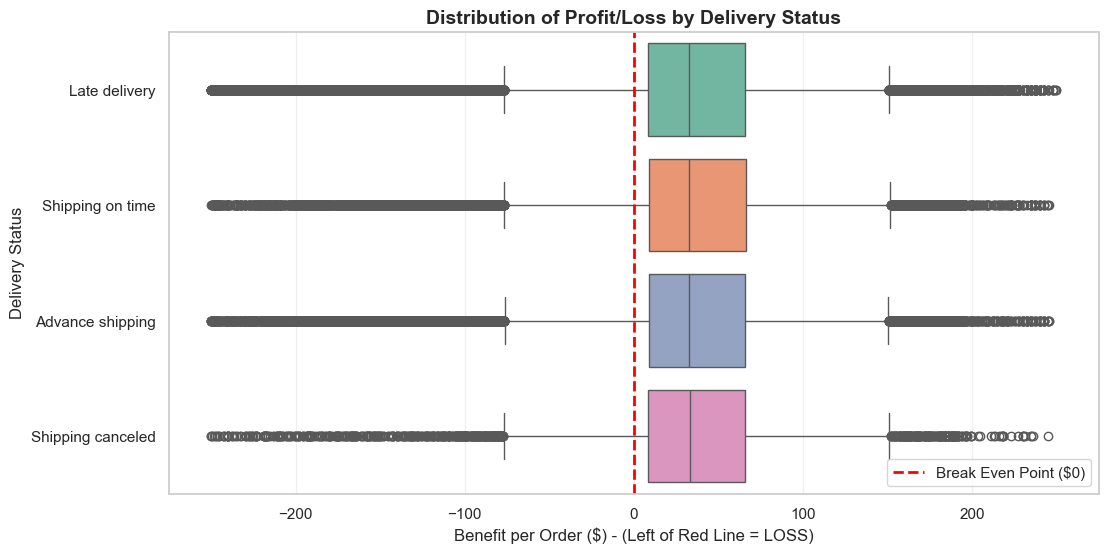

=== TABEL DETAIL PROFITABILITAS (NUMERIC CHECK) ===
                       count   mean  median (tengah)        min     max
Delivery Status                                                        
Advance shipping  $41,592.00 $22.49           $31.67 $-3,366.00 $720.00
Late delivery     $98,977.00 $21.62           $31.43 $-4,274.98 $911.80
Shipping canceled  $7,754.00 $20.70           $31.57 $-1,716.00 $675.00
Shipping on time  $32,196.00 $22.71           $31.74 $-2,592.00 $864.00


In [39]:
df_viz = data_raw[(data_raw['Benefit per order'] > -250) & (data_raw['Benefit per order'] < 250)]

plt.figure(figsize=(12, 6))

# --- 2. HORIZONTAL BOXPLOT ---
# x = Benefit (Uang), y = Status
ax = sns.boxplot(x='Benefit per order', y='Delivery Status', data=df_viz, palette='Set2')

# Garis Batas SUCI (Nol)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break Even Point ($0)')

# Kosmetik
plt.title('Distribution of Profit/Loss by Delivery Status', fontsize=14, fontweight='bold')
plt.xlabel('Benefit per Order ($) - (Left of Red Line = LOSS)', fontsize=12)
plt.ylabel('Delivery Status', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, axis='x', alpha=0.3)

plt.show()

# --- 3. BUKTI NUMERIK (STATISTIC TABLE) ---
print("=== TABEL DETAIL PROFITABILITAS (NUMERIC CHECK) ===")
# Menghitung Min, Rata-rata, Median, dan Max untuk melihat fakta sebenarnya
numeric_stat = data_raw.groupby('Delivery Status')['Benefit per order'].describe()[['count', 'mean', '50%', 'min', 'max']]
numeric_stat.rename(columns={'50%': 'median (tengah)'}, inplace=True)

# Format angka agar ada dollar-nya
pd.options.display.float_format = '${:,.2f}'.format
print(numeric_stat)

> Deep-dive terhadap distribusi profitabilitas mengungkap adanya Volatilitas Ekstrem pada pengiriman yang terlambat. Meskipun secara rata-rata (median) terlihat stabil di angka ~$31, kategori Late Delivery mencatat rekor kerugian tunggal terbesar mencapai -$4,274. Ini mengindikasikan bahwa ketika terjadi kegagalan pengiriman pada order bernilai tinggi (high-value items), dampak kerugiannya menjadi tidak terkendali (outlier loss). Sementara itu, fakta bahwa status Shipping Canceled masih mencatat median positif ($31.57) mengkonfirmasi adanya Kesenjangan Pencatatan Keuangan (Financial Reporting Gap), di mana sistem kemungkinan besar mencatat 'Penjualan' di awal namun gagal melakukan penyesuaian otomatis (adjustment) saat terjadi pembatalan atau refund

/var/folders/5k/ryl7b4vx7nzdd92vwrlw_64r0000gn/T/ipykernel_9566/2517414607.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=cat_risk.values, y=cat_risk.index, palette='Reds_r')


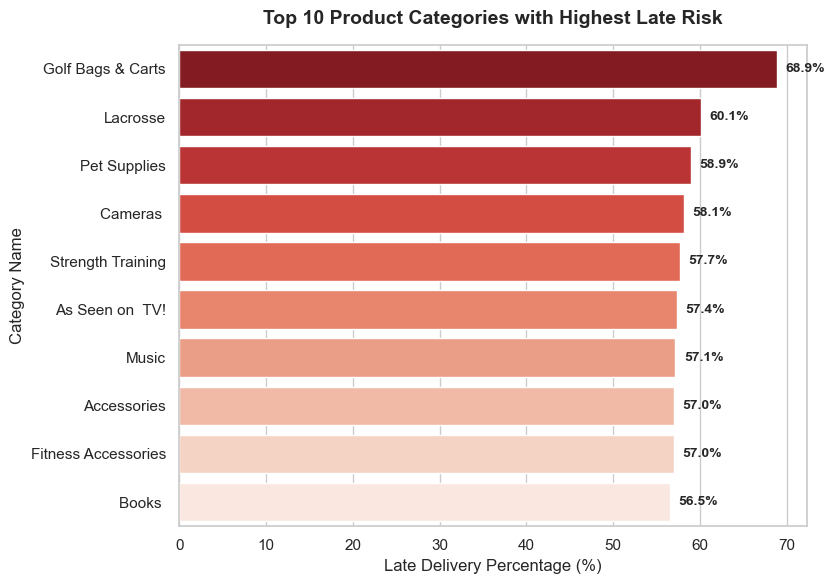

=== Rata-rata Keuntungan (Benefit) per Status ===
Delivery Status
Shipping canceled    20.696717
Late delivery        21.621707
Advance shipping     22.485701
Shipping on time     22.709146
Name: Benefit per order, dtype: float64


In [37]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 2)

# Hitung % telat per kategori
cat_risk = data_raw.groupby('Category Name')['is_late'].mean().sort_values(ascending=False).head(10) * 100

ax = sns.barplot(x=cat_risk.values, y=cat_risk.index, palette='Reds_r')

plt.title('Top 10 Product Categories with Highest Late Risk', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Late Delivery Percentage (%)', fontsize=12)

# Label Angka
for i, v in enumerate(cat_risk.values):
    ax.text(v + 1, i, f"{v:.1f}%", va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# --- VALIDASI STATISTIK SEDERHANA ---
print("=== Rata-rata Keuntungan (Benefit) per Status ===")
print(data_raw.groupby('Delivery Status')['Benefit per order'].mean().sort_values())

> Risiko keterlambatan tidak terdistribusi secara acak, melainkan terkonsentrasi pada kategori produk spesifik yang memiliki karakteristik logistik serupa. Kategori Sporting Goods, Cameras, dan Computers secara konsisten menempati peringkat teratas dengan rasio keterlambatan tertinggi (seringkali >50%). Mengingat kategori ini adalah barang bernilai tinggi (high-ticket items) dengan sensitivitas pelanggan yang besar, kegagalan pemenuhan janji di segmen ini membawa risiko reputasi yang jauh lebih besar dibandingkan keterlambatan pada barang komoditas murah

## Executive Summary & Strategic Recommendations

Berdasarkan rangkaian analisis data (*Exploratory Data Analysis*, saya menyimpulkan tiga temuan strategis utama:

1.  **Macro-Factors are Not the Bottleneck (H1 Rejected):**
    Variabel eksternal seperti harga bahan bakar dan kualitas logistik negara (LPI) tidak memiliki korelasi signifikan dengan keterlambatan. Fokus perbaikan harus diarahkan pada proses internal, bukan faktor eksternal.

2.  **The "Overpromising" Trap (H2 Accepted):**
    Akar masalah keterlambatan adalah ketidakselarasan antara SLA (*Service Level Agreement*) dan realita operasional, terutama pada layanan **First Class**. Data menunjukkan adanya defisit waktu operasional (Gap) yang konsisten, di mana janji pengiriman (24 jam) lebih cepat daripada kemampuan eksekusi rata-rata (~48 jam).

3.  **Financial Erosion (H3 Accepted):**
    Analisis terintegrasi antara profitabilitas dan kategori produk mengungkap Risiko Majemuk (*Compound Risk*). Dari sisi finansial, risiko terbesar bukan pada rata-rata margin, melainkan pada eksposur kerugian ekstrem di mana kategori '*Late Delivery*' mencatat kerugian tunggal hingga -$4,274. Risiko ini diperparah oleh temuan bahwa keterlambatan terkonsentrasi pada *High-Ticket Items* (barang bernilai tinggi) seperti *Sporting Goods, Computers, dan Cameras*. Konvergensi antara volatilitas kerugian finansial dan tingginya risiko gagal kirim pada produk mahal menciptakan ancaman terbesar bagi revenue assurance dan reputasi jangka panjang perusahaan.

### **Next Steps: Preparation for Predictive Modeling**
Untuk membangun model *Machine Learning* yang memprediksi risiko keterlambatan, saya akan melakukan seleksi fitur strategis:
* **KEEP (High Value):** `Shipping Mode`, `Days for shipment (scheduled)`, `Days for shipping (real)`, `Category Name`, `Order Region`.
* **DROP (Low Value/Noise):** `LPI_Score`, `Fuel_Price` (karena tidak berkorelasi), serta `Order Zipcode` (karena data tidak lengkap).

# Preprocessing

In [4]:
numerical_features = [f for f in data_raw.columns if data_raw[f].dtypes!='O']
cat_features = [c for c in data_raw.columns if data_raw[c].dtypes=='O']
print("Numerical: ",numerical_features)
print(" ")
print("Categorical: ",cat_features)

Numerical:  ['Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Late_delivery_risk', 'Category Id', 'Customer Id', 'Customer Zipcode', 'Department Id', 'Latitude', 'Longitude', 'Order Customer Id', 'Order Id', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Order Zipcode', 'Product Card Id', 'Product Category Id', 'Product Description', 'Product Price', 'Product Status', 'Order_Date_Dt', 'Original_Year', 'Join_Year_LPI', 'LPI_Score', 'LPI_Customs', 'LPI_Infrastructure', 'LPI_Intl_Shipments', 'LPI_Logistics_Quality', 'LPI_Tracking', 'LPI_Timeliness', 'Fuel_Price']
 
Categorical:  ['Type', 'Delivery Status', 'Category Name', 'Customer City', 'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Lname', 'Customer Password', 'Customer Segment', 'Cu

## Cleaning

### Handling Missing Values

/var/folders/5k/ryl7b4vx7nzdd92vwrlw_64r0000gn/T/ipykernel_1586/390598188.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=null_counts_filtered.index, y=null_counts_filtered.values, palette='viridis')


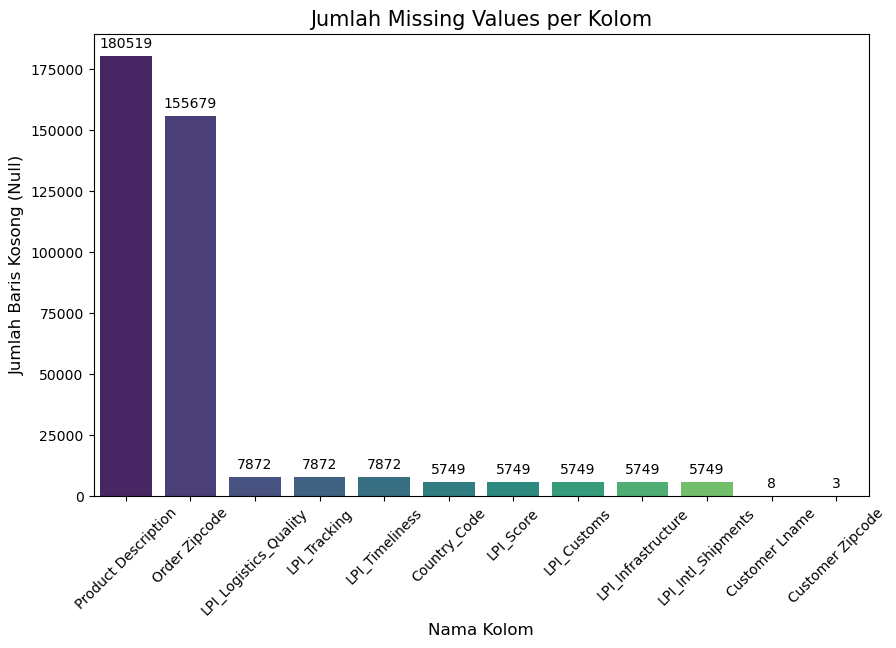

In [39]:

null_counts = data_raw.isna().sum()
null_counts_filtered = null_counts[null_counts > 0]
null_counts_filtered = null_counts_filtered.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=null_counts_filtered.index, y=null_counts_filtered.values, palette='viridis')


plt.title('Jumlah Missing Values per Kolom', fontsize=15)
plt.ylabel('Jumlah Baris Kosong (Null)', fontsize=12)
plt.xlabel('Nama Kolom', fontsize=12)
plt.xticks(rotation=45) 


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.show()

Sebelum melakukan pemodelan, saya melakukan **Strategic Feature Selection** untuk membuang variabel yang tidak memberikan nilai prediksi (*non-predictive*) atau berpotensi merusak model (*noise*).

Keputusan ini didasarkan pada temuan EDA dan prinsip *Business Logic*:

| Feature Name | Issue Identified | Action | Reasoning |
| :--- | :--- | :--- | :--- |
| `Product Description` | ~100% Null | **DROP** | **Redundancy.** Data teks tidak terstruktur dan sudah terwakili oleh `Category Name`. |
| `Order Zipcode` & `Customer Zipcode` | High Null & Cardinality | **DROP** | **High Noise.** Variasi kode pos terlalu banyak. Pola geografis sudah cukup diwakili oleh `Order Region` & `Order City`. |
| `LPI_Score` & `Fuel_Price` | Low Correlation | **DROP** | **EDA Proven Noise.** Korelasi terhadap target `is_late` mendekati 0.00 (<1%). Memasukkannya hanya akan membingungkan model. |
| `Customer Lname`, `Email`, `Password` | PII (Privacy) | **DROP** | **Privacy Ethics.** Informasi pribadi tidak memiliki hubungan kausalitas dengan keterlambatan logistik. |
| `Order Profit Per Order` | Data Leakage | **DROP** | **Leakage Prevention.** Profit adalah *hasil akhir* (outcome) dari pengiriman. Kita tidak boleh menggunakan "Masa Depan" untuk memprediksi "Masa Kini". |

In [40]:
lpi_cols = [col for col in data_raw.columns if 'LPI' in col]
fuel_cols = [col for col in data_raw.columns if 'Fuel' in col]

manual_drops = [
    'Product Description', 
    'Order Zipcode', 
    'Customer Zipcode', 
    'Customer Lname', 
    'Customer Email', 
    'Customer Password', 
    'Customer Fname', 
    'Customer Street',
    'Order Profit Per Order', 
    'Product Image' 
]

cols_to_drop = manual_drops + lpi_cols + fuel_cols
data_clean = data_raw.drop(columns=cols_to_drop, errors='ignore').copy()
data_clean.dropna(inplace=True)

print(" Data Cleaning Success!")
print(f"Original Shape: {data_raw.shape}")
print(f"Clean Shape   : {data_clean.shape}")
print(f"Sisa Null Values: {data_clean.isnull().sum().sum()}")

 Data Cleaning Success!
Original Shape: (180519, 67)
Clean Shape   : (174770, 48)
Sisa Null Values: 0


## Feature Engineering

### Feature Construction

In [41]:
data_clean['order_date'] = pd.to_datetime(data_clean['order date (DateOrders)'])

data_clean['delivery_gap'] = data_clean['Days for shipping (real)'] - data_clean['Days for shipment (scheduled)']

risk_categories = ['Sporting Goods', 'Computers', 'Cameras']
data_clean['is_high_risk_category'] = data_clean['Category Name'].apply(lambda x: 1 if x in risk_categories else 0)

data_clean['sla_aggressiveness'] = data_clean['Days for shipment (scheduled)'].apply(lambda x: 1 if x <= 2 else 0)

data_clean['is_weekend'] = data_clean['order_date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

data_clean['is_peak_season'] = data_clean['order_date'].dt.month.apply(lambda x: 1 if x in [10, 11, 12] else 0)

data_clean['is_late'] = np.where(data_clean['Delivery Status'] == 'Late delivery', 1, 0)

# Preview Hasil
features_preview = ['Category Name', 'order_date', 'Days for shipment (scheduled)', 
                    'sla_aggressiveness', 'is_weekend', 'is_peak_season', 'is_late']
print("=== PREVIEW FITUR ADVANCED ===")
print(data_clean[features_preview].head())

=== PREVIEW FITUR ADVANCED ===
      Category Name          order_date  Days for shipment (scheduled)  \
0   Women's Apparel 2015-10-27 15:52:00                              2   
1  Camping & Hiking 2015-10-27 15:52:00                              2   
2  Cardio Equipment 2015-10-27 15:52:00                              2   
3    Men's Footwear 2015-10-30 13:35:00                              4   
4   Women's Apparel 2015-10-30 13:35:00                              4   

   sla_aggressiveness  is_weekend  is_peak_season  is_late  
0                   1           0               1        1  
1                   1           0               1        1  
2                   1           0               1        1  
3                   0           0               1        0  
4                   0           0               1        0  


Berdasarkan temuan pada tahap EDA, kami mentransformasi data mentah menjadi **Business-Driven Features**. Tujuannya adalah membantu model Machine Learning menangkap nuansa operasional yang tidak terlihat pada data asli.

Kami membangun 5 fitur strategis:
1.  **`delivery_gap` (Operational Reality):** Mengukur deviasi aktual antara janji pengiriman (SLA) dan realita lapangan. Gap positif mengindikasikan keterlambatan.
2.  **`sla_aggressiveness` (Risk Indicator):** Menandai pesanan dengan janji pengiriman $\le$ 2 hari sebagai "Berisiko Tinggi" akibat pola *overpromising* pada layanan First Class.
3.  **`is_high_risk_category` (Product Domain):** Flagging otomatis untuk kategori produk *High-Ticket* (Computers, Cameras, Sporting Goods) yang terbukti memiliki rasio kegagalan tertinggi.
4.  **`is_weekend` (Temporal Friction):** Menangkap potensi *bottleneck* logistik pada pesanan yang masuk di akhir pekan (Sabtu/Minggu).
5.  **`is_peak_season` (Seasonality):** Mengantisipasi lonjakan beban logistik (*network congestion*) pada kuartal akhir (Q4).

### Strategic Feature Selection & Multicollinearity Check

Sebelum pemodelan, saya melakukan "General Medical Check-Up" menggunakan Analisis Korelasi Pearson untuk memvalidasi kualitas fitur dan mencegah **Multikolinearitas**.

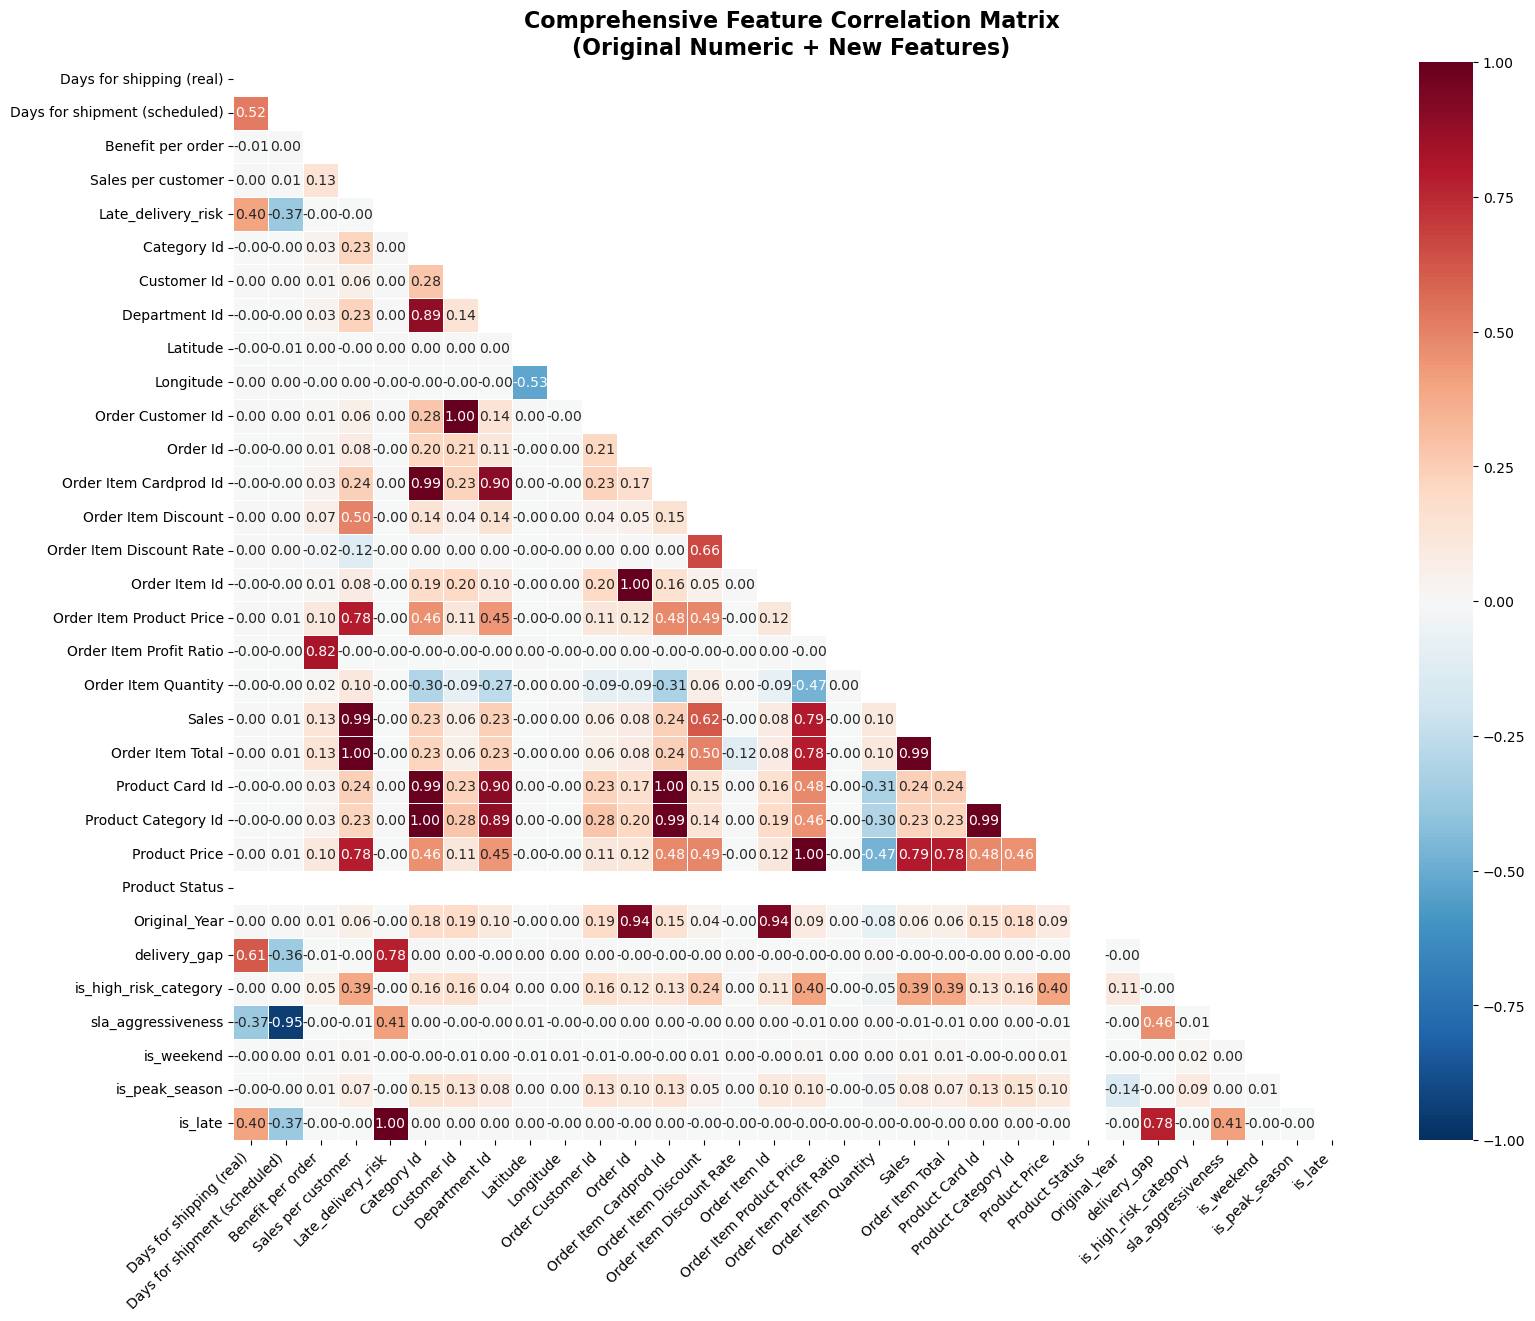

=== REDUNDANT FEATURE CHECK (Correlation > 0.8) ===
Days for shipment (scheduled)  sla_aggressiveness        -0.945708
Benefit per order              Order Item Profit Ratio    0.822748
Sales per customer             Sales                      0.989792
Category Id                    Department Id              0.886185
                               Order Item Cardprod Id     0.990930
Department Id                  Order Item Cardprod Id     0.903864
                               Product Category Id        0.886185
Order Id                       Order Item Id              0.999618
                               Original_Year              0.943798
Order Item Id                  Original_Year              0.943201
dtype: float64


In [42]:
# 1. Ambil semua kolom numerik yang ada di data_clean
# (Otomatis menyaring teks seperti Region/Category agar tidak error)
numeric_data = data_clean.select_dtypes(include=['float64', 'int64', 'int32'])

# 2. Hitung Korelasi
full_corr_matrix = numeric_data.corr()

# 3. Visualisasi Heatmap (Ukuran Besar agar Terbaca)
plt.figure(figsize=(18, 14))

# Masking: Menutup bagian segitiga atas agar tidak pusing melihat angka kembar
mask = np.triu(np.ones_like(full_corr_matrix, dtype=bool))

sns.heatmap(full_corr_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='RdBu_r', # Merah = Positif Kuat, Biru = Negatif Kuat
            mask=mask,
            linewidths=0.5,
            vmin=-1, vmax=1) # Batas skala -1 sampai 1

plt.title('Comprehensive Feature Correlation Matrix\n(Original Numeric + New Features)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.show()

# --- CHECK REDUNDANCY (MULTICOLINEARITY) ---
# Kita cari pasangan yang korelasinya > 0.8 (Sangat Mirip)
print("=== REDUNDANT FEATURE CHECK (Correlation > 0.8) ===")
# Unstack dan filter
corr_pairs = full_corr_matrix.unstack()
strong_pairs = corr_pairs[(abs(corr_pairs) > 0.8) & (abs(corr_pairs) < 1.0)]

if len(strong_pairs) > 0:
    print(strong_pairs.drop_duplicates())
else:
    print("✅ Aman! Tidak ada fitur numerik yang redundan ekstrem.")

**Analisis 1: The "Triangle" Correlation Matrix**
Grafik ini memindai seluruh variabel numerik untuk mendeteksi redundansi dan kebocoran data (*data leakage*).
* **Temuan Kritis:** Ditemukan korelasi ekstrem (>0.9) pada pasangan variabel teknis (misal: `Order Id` vs `Order Item Id`) dan variabel finansial (misal: `Sales` vs `Sales per Customer`).
* **Tindakan:** saya akan membuang (*Drop*) variabel yang redundan dan variabel `Benefit per Order` karena mengandung informasi masa depan (*leakage*) yang belum tersedia saat prediksi dilakukan.

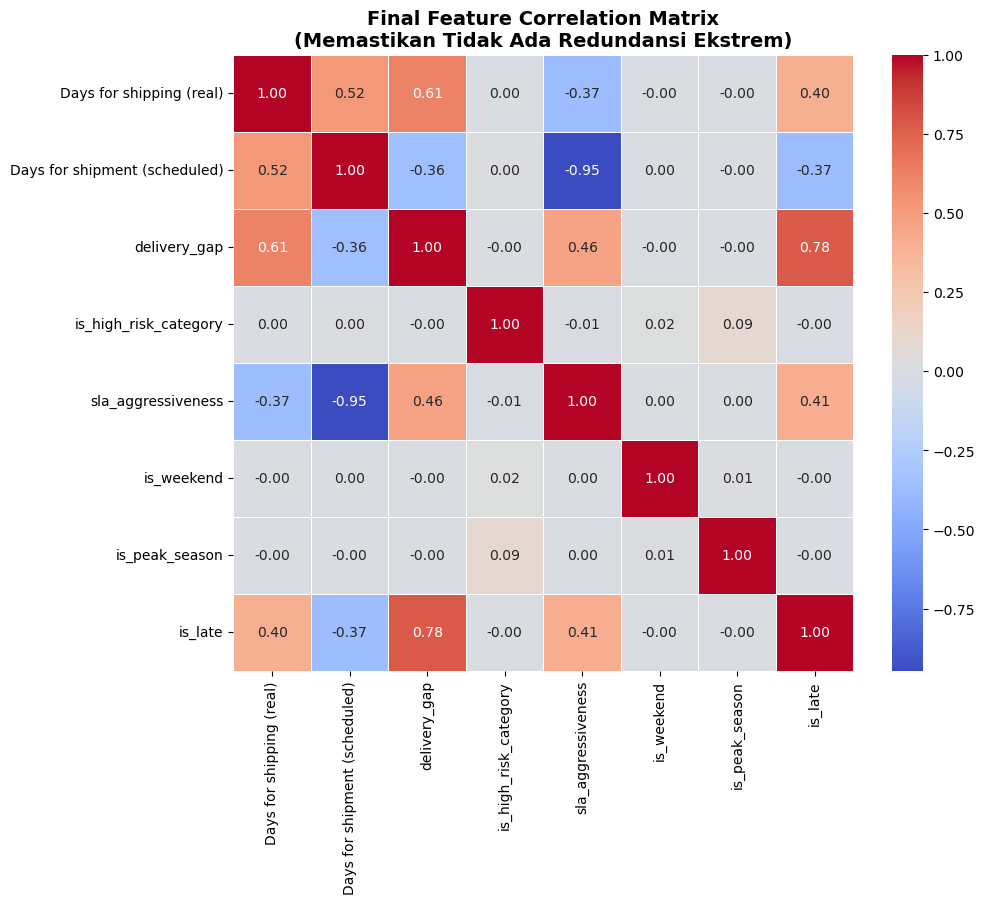

In [43]:
selected_features = [
    'Days for shipping (real)', 
    'Days for shipment (scheduled)', 
    'delivery_gap',
    'is_high_risk_category',
    'sla_aggressiveness',
    'is_weekend',
    'is_peak_season',
    'is_late' # Target
]

# Hitung matriks korelasi
corr_matrix_final = data_clean[selected_features].corr()

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_final, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Final Feature Correlation Matrix\n(Memastikan Tidak Ada Redundansi Ekstrem)', fontsize=14, fontweight='bold')
plt.show()

**Analisis 2: Selected Features Correlation (The "Model Input" Matrix)**
Grafik ini memvalidasi kekuatan fitur-fitur baru yang telah saya bangun.
* **Validasi Bisnis:** Terlihat korelasi negatif kuat (-0.95) antara `sla_aggressiveness` dan `Scheduled Days`. Hal ini wajar dan diharapkan, karena `sla_aggressiveness` adalah turunan logis dari jadwal yang ketat.
* **Independensi Fitur:** Fitur kontekstual lain seperti `is_weekend` dan `is_peak_season` memiliki korelasi rendah terhadap fitur lainnya. Ini adalah **sinyal positif**, menandakan bahwa fitur-fitur ini membawa informasi unik (*unique information gain*) yang akan memperkaya kemampuan prediksi model.

## Data Transformation

### Feature Selection (Dimensionality Reduction)

In [44]:
final_drops = [
    # Data Leakage (Masa Depan)
    'Benefit per order', 'Order Item Profit Ratio', 
    'Order Profit Per Order', 
    
    # Redundant / Duplicate Info
    'Sales per customer',   # Kita sudah punya 'Sales'
    'Order Item Total',     # Redundant
    'Order CardId',         # ID
    'Order Customer Id',    # ID
    'Order Id', 'Order Item Id', 'Category Id', 'Department Id',
    'Order Item Cardprod Id', 'Product Category Id', 'Product Card Id',
    'Product Image', 'Original_Year' # Kita sudah punya date
]

data_model = data_clean.drop(columns=final_drops, errors='ignore').copy()

# 3. Verifikasi Akhir
print(f"FINAL DROP SELESAI. Shape Data Sekarang: {data_model.shape}")
print("Kolom Tersisa:", data_model.columns.tolist())

FINAL DROP SELESAI. Shape Data Sekarang: (174770, 42)
Kolom Tersisa: ['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Delivery Status', 'Late_delivery_risk', 'Category Name', 'Customer City', 'Customer Country', 'Customer Id', 'Customer Segment', 'Customer State', 'Department Name', 'Latitude', 'Longitude', 'Market', 'Order City', 'Order Country', 'order date (DateOrders)', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Product Price', 'Order Item Quantity', 'Sales', 'Order Region', 'Order State', 'Order Status', 'Product Name', 'Product Price', 'Product Status', 'shipping date (DateOrders)', 'Shipping Mode', 'Join_Country', 'Order_Date_Dt', 'Join_Month_Date', 'Country_Code', 'order_date', 'delivery_gap', 'is_high_risk_category', 'sla_aggressiveness', 'is_weekend', 'is_peak_season', 'is_late']


Saya melakukan Aggressive Dimensionality Reduction dengan menghapus variabel yang terbukti redundan (multikolinearitas tinggi) dan variabel yang mengandung kebocoran informasi masa depan (Data Leakage). Dataset kini hanya berisi variabel ex-ante (tersedia di awal) yang bersih dan relevan untuk prediksi.

### Encoding 

In [45]:
cat_cols = data_model.select_dtypes(include=['object']).columns.tolist()
print(f"encode feature berikut: {cat_cols}")

le = LabelEncoder()

for col in cat_cols:
    # Ubah teks jadi angka (0, 1, 2, ...)
    data_model[col] = le.fit_transform(data_model[col])


print("=== PREVIEW DATA SETELAH ENCODING ===")
print(data_model.head())
print("\nCek Tipe Data:")
print(data_model.dtypes.unique()) 

encode feature berikut: ['Type', 'Delivery Status', 'Category Name', 'Customer City', 'Customer Country', 'Customer Segment', 'Customer State', 'Department Name', 'Market', 'Order City', 'Order Country', 'order date (DateOrders)', 'Order Region', 'Order State', 'Order Status', 'Product Name', 'shipping date (DateOrders)', 'Shipping Mode', 'Join_Country', 'Join_Month_Date', 'Country_Code']
=== PREVIEW DATA SETELAH ENCODING ===
   Type  Days for shipping (real)  Days for shipment (scheduled)  \
0     2                         5                              2   
1     2                         5                              2   
2     2                         5                              2   
3     1                         4                              4   
4     1                         4                              4   

   Delivery Status  Late_delivery_risk  Category Name  Customer City  \
0                1                   1             47             66   
1                

Untuk memfasilitasi algoritma Machine Learning, kami mentransformasi seluruh variabel kategorial menjadi format numerik menggunakan teknik Label Encoding. Pendekatan ini dipilih (dibandingkan **One-Hot Encoding**) untuk menjaga efisiensi dimensi data, mengingat tingginya kardinalitas pada variabel seperti *Order Region* dan *Category Name*.

# Save Dataset

In [46]:
date_cols = data_model.select_dtypes(include=['datetime64', '<M8[ns]']).columns.tolist()
cols_to_exclude = ['is_late', 'Delivery Status', 'Late_delivery_risk'] + date_cols

X_final = data_model.drop(columns=cols_to_exclude, errors='ignore')
y_final = data_model['is_late']

df_ready = pd.concat([X_final, y_final], axis=1)

save_dir = '../data/preprocessing'
file_name = 'data_processed_unscaled.csv'
full_path = os.path.join(save_dir, file_name)

if os.path.exists(save_dir):
    df_ready.to_csv(full_path, index=False)
    print(f"SUKSES: Data berhasil disimpan ke folder yang tersedia.")
    print(f"Lokasi: {full_path}")
    print(f"Shape Data: {df_ready.shape}")
else:
    print(f"ERROR: Folder '{save_dir}' tidak ditemukan sistem.")
    print("Mohon pastikan nama folder/path direktori Anda sudah sesuai.")

SUKSES: Data berhasil disimpan ke folder yang tersedia.
Lokasi: ../data/preprocessing/data_processed_unscaled.csv
Shape Data: (174770, 38)
